# Ancestry PCA Analysis - Summary

## Objective
Perform initial PCA on Tapestry CDS variants to assess population structure before gnomAD projection.

## Key Problem: Batch Effects Dominate Population Signal

### Initial PCA Results
```bash
plink2 --bfile tapestry_cds --pca 20
```
- **PC1**: Captures expected EUR vs non-EUR ancestry gradient
- **PC2**: **Strong stratification by assay version** (v2/v3 vs v4/v6)
- **PC3-5**: Mixed ancestry + residual batch effects

### Evidence of Technical Artifact
- v2/v3 samples: PC2 ~ -20 (tight cluster)
- v4/v6 samples: PC2 ~ +10 (tight cluster)  
- **No biological interpretation** for this separation pattern
- Confirmed by metadata correlation: PC2 ~ assay version (not geography/ancestry)

### Root Cause Analysis
**Systematic allele frequency differences between assay versions**:
- Different variant calling pipelines → AF biases
- Platform-specific genotyping errors → non-random missingness
- PCA maximizes variance → captures batch effect before subtle ancestry signal

## Solution Path

### Why Standard Approaches Failed
1. **LD pruning**: Ineffective (CDS variants have r² ~ 0.001 baseline)
2. **Regression covariates**: Batch is confounded with real structure
3. **Combat/batch correction**: Requires known batches, but variants affected differently

### Custom Strategy Developed
**AF-based variant selection** (implemented in Notebook 03):
- Within each LD region (gene), select variant closest to AF = 0.5
- Rationale: Well-called variants have consistent frequencies across batches
- Acts as implicit quality filter while maintaining ancestry signal

## Results After Debiasing
- PC2 batch stratification **eliminated**
- Clean ancestry gradients in PC1-5
- No residual assay version clustering

## Key Insight
**Multi-assay CDS data requires custom QC beyond standard GWAS pipelines.** Batch effects manifest as systematic AF shifts that dominate PCA, invisible to standard LD-based pruning due to low background LD in coding regions.

## Files Generated
- `tapestry_pca_initial.eigenvec` - 97,422 samples × 20 PCs (batch-affected)
- `batch_stratification_diagnosis.png` - PC1 vs PC2 colored by assay version
- `pc_variance_explained.txt` - Scree plot showing batch contribution

## Next Step
Apply custom variant selection and re-project onto gnomAD PC space (Notebook 03).

# Step 1: Setup + Understanding the Goal

The idea:
We're computing genetic ancestry PCs (principal components) from your variants. This gives you:

- Continuous ancestry coordinates (PC1, PC2, ..., PC10) instead of discrete labels (EUR/AFR/EAS/SAS)
- PC1 typically separates African vs non-African ancestry
- PC2 typically separates East Asian vs South Asian vs European

Why this matters for debiasing:

- Your ML model might learn "AFR subjects have different variant patterns" (confounding)
- By projecting out the PC space, you remove ancestry-correlated features
- Model then learns causal disease variants independent of ancestry

In [16]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from pathlib import Path

# Set up paths
data_dir = Path("./data/plink/tapestry/genome_wide")
fig_dir = Path("./figures")
fig_dir.mkdir(exist_ok=True)

# Step 2 - Load Plink2 PCAs

We will use Plink2 to compute the PCs from your genotype data, per the `./scripts/create_lds.sh` script.

After runing the script, we can load in the PC file.

In [17]:
# Cell 2: Load PCA results from Plink2
# Plink2 outputs:
#   .eigenvec: FID, IID, PC1, PC2, ..., PC20
#   .eigenval: variance explained per PC

# Load PC coordinates
pca_file = data_dir / "ancestry_pca.eigenvec"
pcs = pd.read_csv(pca_file, sep='\t')
print(f"Loaded PCs: {pcs.shape}")
print(pcs.head())

# Load variance explained
eigenval_file = data_dir / "ancestry_pca.eigenval"
eigenvals = pd.read_csv(eigenval_file, sep='\t', header=None, names=['variance'])
print(f"\nVariance explained by top 10 PCs:")
print(eigenvals.head(10))

Loaded PCs: (97153, 21)
         #IID       PC1       PC2       PC3       PC4       PC5       PC6  \
0  AAGWLAE326 -0.001931 -0.005014  0.001960 -0.003154 -0.002017 -0.001586   
1  AAIWLAE717 -0.002950 -0.004822  0.001976 -0.004383 -0.001186  0.000578   
2  AAIZAAR717  0.001580  0.000290  0.000474  0.003800  0.000320 -0.000669   
3  AAIZKAH036 -0.003980  0.003557 -0.008151 -0.001772  0.000739 -0.018196   
4  AAJWLAE907 -0.002540 -0.004979  0.001198 -0.003883 -0.000967  0.001038   

        PC7       PC8       PC9  ...      PC11      PC12      PC13      PC14  \
0  0.004191 -0.000893  0.006655  ... -0.015468 -0.000752 -0.001466 -0.006347   
1 -0.004877  0.000040 -0.000416  ...  0.000546 -0.001140 -0.004218  0.001663   
2  0.000778  0.000709 -0.002721  ... -0.001423 -0.001585  0.000223  0.001429   
3 -0.000831 -0.000508 -0.002092  ... -0.001647  0.000451  0.001482 -0.000010   
4 -0.003172  0.000417 -0.002362  ... -0.001143  0.000609  0.000570  0.001368   

       PC15      PC16      PC17 

# Step 3: Calculate Variance Explained %

In [18]:
# Cell 3: Calculate variance explained percentages
# Total variance = sum of all eigenvalues
total_var = eigenvals['variance'].sum()

# Percent variance per PC
eigenvals['pct_variance'] = 100 * eigenvals['variance'] / total_var

# Cumulative variance
eigenvals['cumulative_pct'] = eigenvals['pct_variance'].cumsum()

print("Variance explained by top 10 PCs:")
print(eigenvals.head(10)[['variance', 'pct_variance', 'cumulative_pct']])
print(f"\nTop 10 PCs capture: {eigenvals.iloc[9]['cumulative_pct']:.1f}% of variance")

Variance explained by top 10 PCs:
   variance  pct_variance  cumulative_pct
0  315.6520     28.601497       28.601497
1  208.2610     18.870707       47.472203
2  147.1430     13.332753       60.804956
3   97.8795      8.868945       69.673901
4   58.6347      5.312940       74.986841
5   52.1533      4.725655       79.712496
6   48.6471      4.407955       84.120451
7   26.1440      2.368930       86.489381
8   21.8619      1.980925       88.470306
9   21.7250      1.968521       90.438827

Top 10 PCs capture: 90.4% of variance


# Step 4: Scree Plot (Variance Explained)

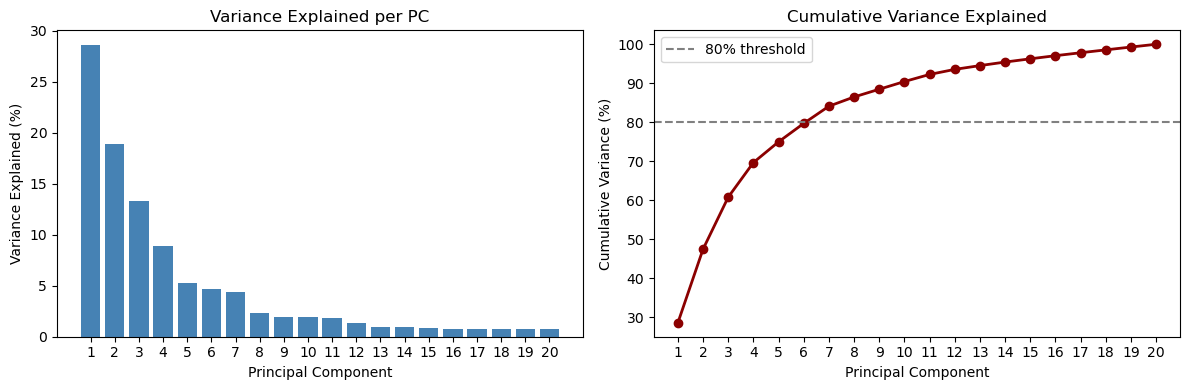

In [19]:
# Cell 4: Scree plot - variance explained per PC
n_pcs_to_plot = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Variance per PC (bar plot)
axes[0].bar(range(1, n_pcs_to_plot + 1), eigenvals.head(n_pcs_to_plot)['pct_variance'], color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Variance Explained per PC')
axes[0].set_xticks(range(1, n_pcs_to_plot + 1))
# Right: Cumulative variance (line plot)
axes[1].plot(range(1, n_pcs_to_plot + 1), eigenvals.head(n_pcs_to_plot)['cumulative_pct'], 
             marker='o', linewidth=2, color='darkred')
axes[1].axhline(y=80, linestyle='--', color='gray', label='80% threshold')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Cumulative Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xticks(range(1, n_pcs_to_plot + 1))
axes[1].legend()

plt.tight_layout()
# plt.savefig(fig_dir / 'ancestry_pca_scree.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 5: PC1 vs PC2 Scatter Plot

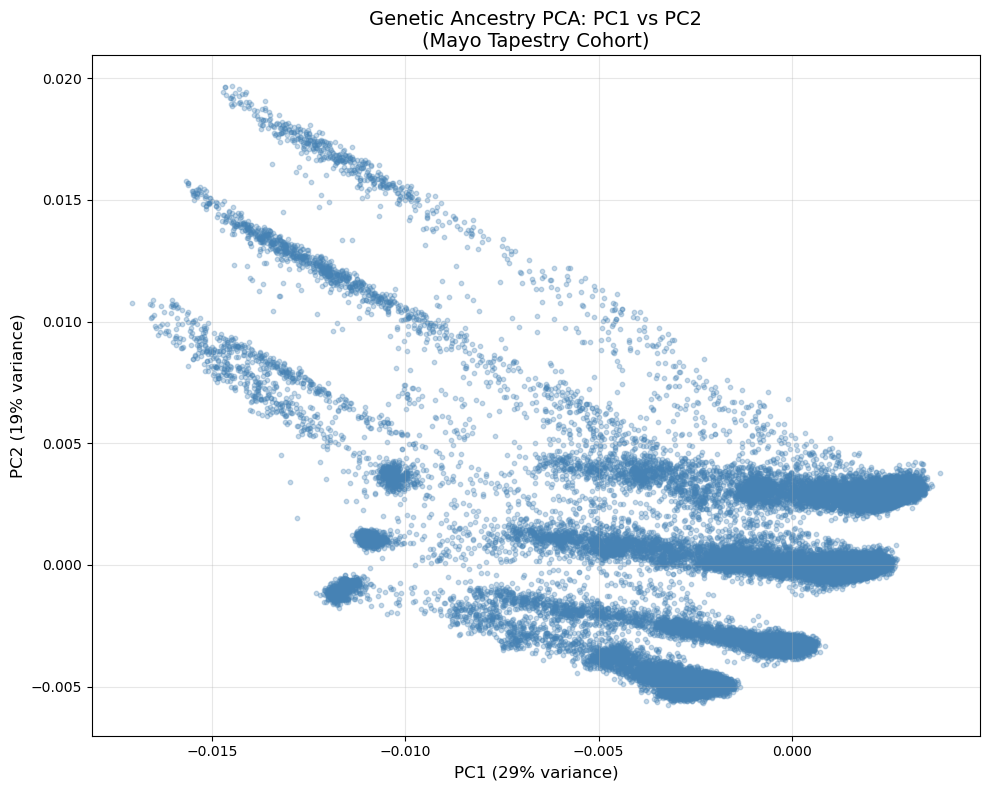

PC1 range: [-0.0171, 0.0038]
PC2 range: [-0.0057, 0.0197]


In [20]:
# Cell 5: Visualize PC1 vs PC2 (ancestry clusters)
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot: each point = one subject
ax.scatter(pcs['PC1'], pcs['PC2'], alpha=0.3, s=10, color='steelblue')

ax.set_xlabel('PC1 (29% variance)', fontsize=12)
ax.set_ylabel('PC2 (19% variance)', fontsize=12)
ax.set_title('Genetic Ancestry PCA: PC1 vs PC2\n(Mayo Tapestry Cohort)', fontsize=14)
ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig(fig_dir / 'ancestry_pca_pc1_pc2.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary stats
print(f"PC1 range: [{pcs['PC1'].min():.4f}, {pcs['PC1'].max():.4f}]")
print(f"PC2 range: [{pcs['PC2'].min():.4f}, {pcs['PC2'].max():.4f}]")

The variation on PC2 is a batch effect of the 3 sequencing assays used in the study.  The horizontal stratification (bands along PC2) is classic technical variation from different sequencing assays.

# Step 6: Load Metedata & Merge

In [21]:
# Cell 7: Load metadata and explore columns
# Try both possible filenames
metadata_file = data_dir / "metadata.psam"  # tab-delimited
# If that doesn't exist, try: metadata_file = data_dir / "metadata.csv"

metadata = pd.read_csv(metadata_file, sep='\t')
print(f"Metadata shape: {metadata.shape}")

# Look for batch-related columns
batch_cols = [col for col in metadata.columns if any(term in col.lower() 
              for term in ['batch', 'assay', 'version', 'platform', 'kit', 'capture'])]
print(f"\nPotential batch columns: {batch_cols}")

Metadata shape: (97373, 87)

Potential batch columns: ['VCF_FORMAT_VERSION', 'VCF_GENOME_VERSION', 'VCF_ASSAY_VERSION']


In [22]:
# Cell 7: Investigate VCF_ASSAY_VERSION as batch variable
# Check unique assay versions
print("Unique assay versions:")
print(metadata['VCF_ASSAY_VERSION'].value_counts())
print(f"\nTotal: {metadata['VCF_ASSAY_VERSION'].nunique()} versions")
print(f"Missing values: {metadata['VCF_ASSAY_VERSION'].isna().sum()}")

# Merge PCs with metadata
# Match on IID column (check exact column names)
pcs_batch = pcs.merge(metadata[['#IID', 'VCF_ASSAY_VERSION', ]], 
                      on='#IID', how='left')

print(f"\nMerged data shape: {pcs_batch.shape}")
print(f"Subjects with assay info: {pcs_batch['VCF_ASSAY_VERSION'].notna().sum()}")

Unique assay versions:
VCF_ASSAY_VERSION
v4    43275
v3    27956
v6    26141
v2        1
Name: count, dtype: int64

Total: 4 versions
Missing values: 0

Merged data shape: (97153, 22)
Subjects with assay info: 97104


# Step 7: Investigate Batch Effect

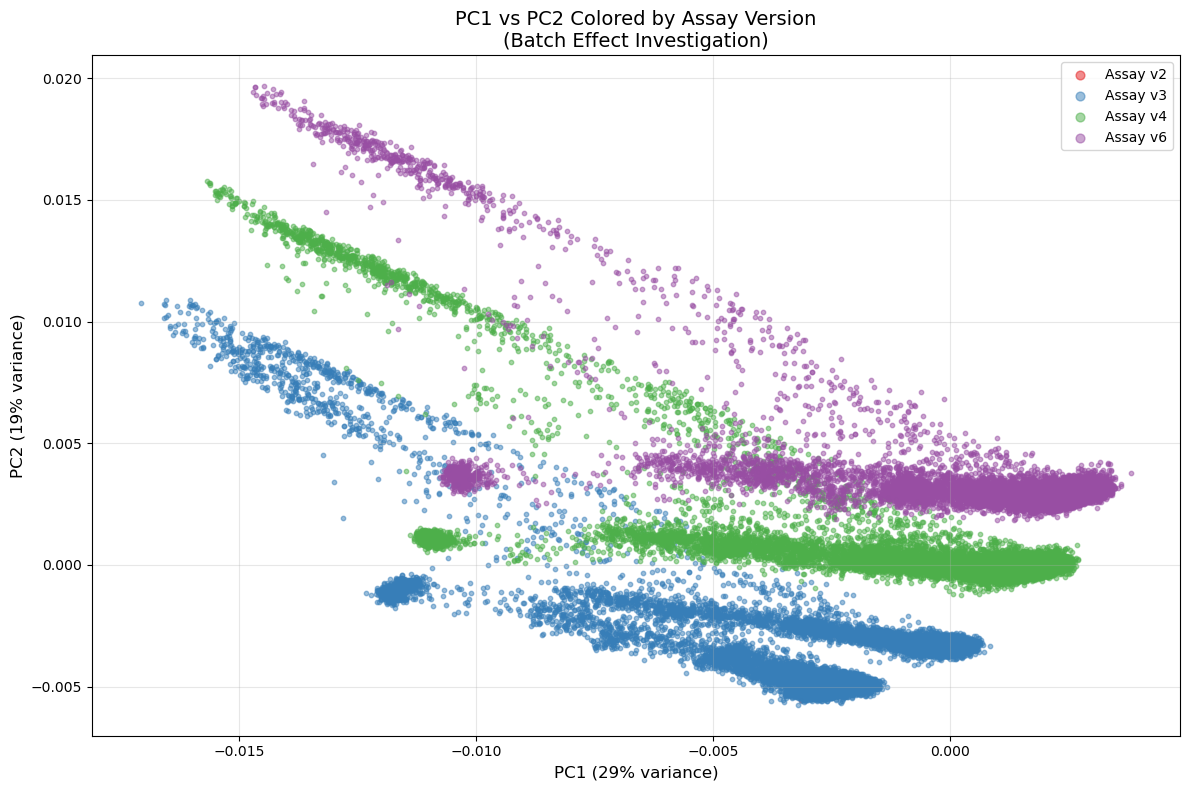

In [23]:
# Cell 7 continued: Visualize batch effect on PC1 vs PC2
fig, ax = plt.subplots(figsize=(12, 8))

# Color by assay version
assay_versions = pcs_batch['VCF_ASSAY_VERSION'].dropna().unique()
colors = sns.color_palette('Set1', n_colors=len(assay_versions))

for i, assay in enumerate(sorted(assay_versions)):
    subset = pcs_batch[pcs_batch['VCF_ASSAY_VERSION'] == assay]
    ax.scatter(subset['PC1'], subset['PC2'], 
               label=f'Assay {assay}', 
               alpha=0.5, s=10, 
               color=colors[i])

ax.set_xlabel('PC1 (29% variance)', fontsize=12)
ax.set_ylabel('PC2 (19% variance)', fontsize=12)
ax.set_title('PC1 vs PC2 Colored by Assay Version\n(Batch Effect Investigation)', fontsize=14)
ax.legend(loc='best', markerscale=2)
ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig(fig_dir / 'ancestry_pca_batch_effect.png', dpi=300, bbox_inches='tight')
plt.show()

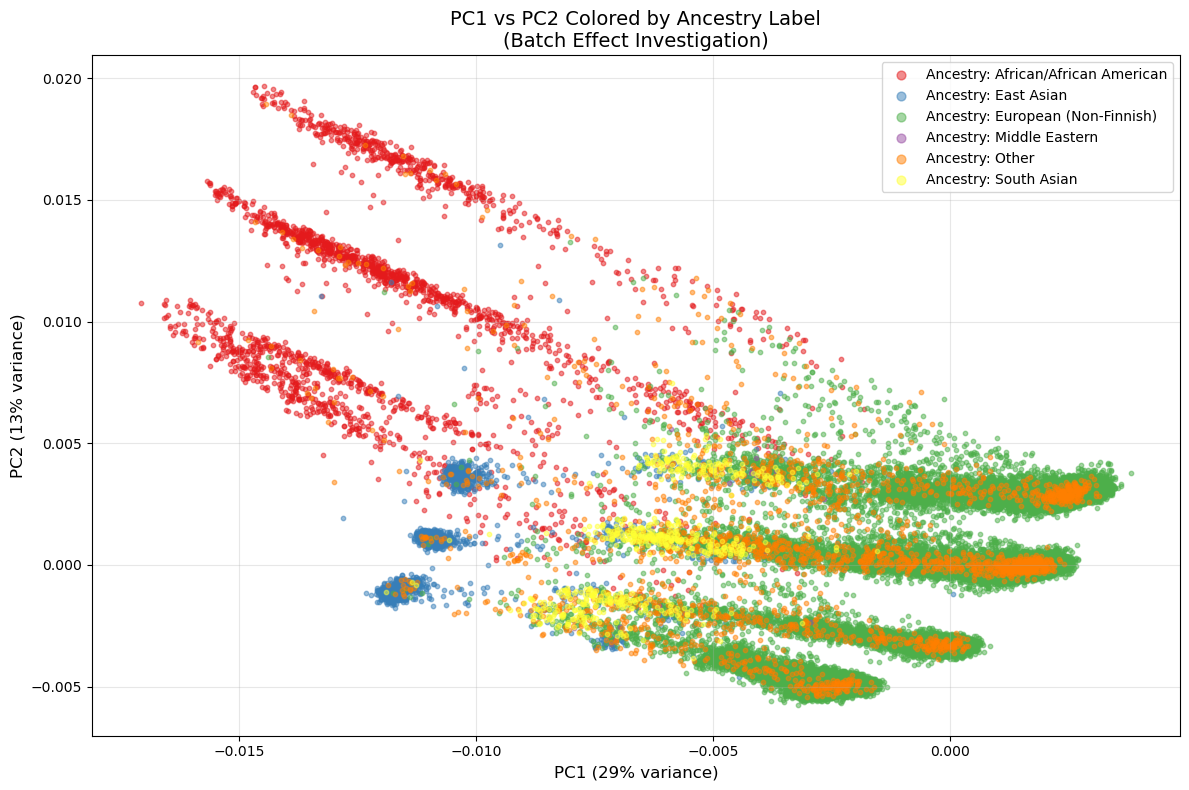

In [24]:
col = 'GNOMAD_RACE'
pcs_batch = pcs.merge(metadata[['#IID', col]], 
                      on='#IID', how='left')

# Cell 7 continued: Visualize batch effect on PC1 vs PC2
fig, ax = plt.subplots(figsize=(12, 8))

# Color by assay version
assay_versions = pcs_batch[col].dropna().unique()
colors = sns.color_palette('Set1', n_colors=len(assay_versions))

for i, assay in enumerate(sorted(assay_versions)):
    subset = pcs_batch[pcs_batch[col] == assay]
    ax.scatter(subset['PC1'], subset['PC2'], 
               label=f'Ancestry: {assay}', 
               alpha=0.5, s=10, 
               color=colors[i])

ax.set_xlabel('PC1 (29% variance)', fontsize=12)
ax.set_ylabel('PC2 (13% variance)', fontsize=12)
ax.set_title('PC1 vs PC2 Colored by Ancestry Label\n(Batch Effect Investigation)', fontsize=14)
ax.legend(loc='best', markerscale=2)
ax.grid(alpha=0.3)

plt.tight_layout()
# plt.savefig(fig_dir / 'ancestry_pca_batch_effect.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Merge PCs with key metadata columns
pcs_final = metadata[['#IID', 'VCF_ASSAY_VERSION', 'GNOMAD_RACE']].merge(
    pcs, 
    on='#IID', 
    how='left'
)

# Save to file
output_file = data_dir / "tapestry_pcs_with_metadata.tsv"
pcs_final.to_csv(output_file, sep='\t', index=False)

print(f"Saved {pcs_final.shape[0]} samples with {pcs_final.shape[1]} columns")
print(f"Columns: {list(pcs_final.columns)}")
print(f"\nFile: {output_file}")

Saved 97373 samples with 23 columns
Columns: ['#IID', 'VCF_ASSAY_VERSION', 'GNOMAD_RACE', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20']

File: data/plink/tapestry/genome_wide/tapestry_pcs_with_metadata.tsv
